<a href="https://colab.research.google.com/github/Arunav993/quantum-simulations/blob/main/TFIM/Quantum_Simulation_of_the_TFIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Simulation of the Transverse-Field Ising Model (TFIM)

## 📌 Overview
This notebook presents a **complete, research-oriented workflow** for digitally simulating the
**Transverse-Field Ising Model (TFIM)** using quantum circuits. The TFIM is one of the most
important benchmark models in quantum many-body physics and quantum computation.

It explicitly connect:
- Many-body Hamiltonians → quantum gates
- Trotterized time evolution → executable circuits
- Ideal simulations → noisy hardware execution



---

## 🎯 Objectives
The goal here is to:
1. derive the TFIM Hamiltonian and interpret each term physically
2. map Hamiltonian terms to quantum gates
3. implement Suzuki–Trotter time evolution circuits
4. simulate dynamics for small system sizes (N = 2–4)
5. measure observables such as magnetization and correlations
6. understand digital vs analog quantum simulation trade-offs

---

## 🧠 The Model: TFIM
The transverse-field Ising model captures the competition between:
- **Interaction term**: nearest-neighbor spin–spin coupling
- **Field term**: quantum fluctuations induced by a transverse field

It exhibits:
- Quantum phase transitions
- Non-commuting Hamiltonian terms
- Exactly solvable limits and non-trivial dynamics

---

## 🛠️ Simulation Strategy
We follow the standard **digital quantum simulation** pipeline:

1. Define the target Hamiltonian
2. Decompose it into implementable Pauli strings
3. Apply first-order (and extendable) Trotterization
4. Construct parameterized quantum circuits
5. Execute on simulators or real quantum hardware

---

## 📊 Visualizations
Throughout the notebook, results can be visualized as:
- ⟨Z⟩ magnetization vs time
- Correlation functions ⟨ZᵢZᵢ₊₁⟩
- Circuit depth vs Trotter steps
        
---


## **How TFIM fits into Quantum Simulation**
### ***The TFIM is used because:***

*   Exactly known limits
*   Non-trivial many-body interactions
*   Testbed for quantum algorithms
*   Used in IBM, Google, trapped ions, cold atoms
*   Ideal for digital & analog simulation benchmarks

### ***The goal is to demonstrate how a target Hamiltonian can be:***

* Encoded digitally
* Simulated in time
* Validated using classical solvers
* Extended toward NISQ-era constraints

# **Digital Quantum Simulation of the Transverse-Field Ising Model**

## **Abstract**

This is a comprehensive digital quantum simulation study of the
transverse-field Ising model as a benchmark many-body Hamiltonian.
Classical simulations are used to validate Hamiltonian encoding,
time evolution, and observable dynamics relevant to near-term quantum
devices. Ground-state preparation, real-time dynamics, Trotterized
evolution, finite-size scalability, and open-system effects are analyzed
with extensive visualization.

## **Target Hamiltonian and Physical Motivation**

The first step in any quantum simulation is to clearly specify the
target Hamiltonian whose dynamics we aim to reproduce on a quantum
device.

The TFIM is particularly well suited for digital quantum simulation
because its constituent terms are simple Pauli operators, while
remaining non-commuting and therefore non-trivial to simulate.


\[
H = -J \sum_{i=1}^{N-1} Z_i Z_{i+1} - h \sum_{i=1}^{N} X_i
\]

The Hamiltonian consists of two competing contributions. The first term
describes nearest-neighbor Ising interactions along the z-direction,
favoring aligned spin configurations. The second term introduces a
transverse magnetic field along the x-direction, which induces quantum
fluctuations by locally flipping spins.

Since these two terms do not commute, the resulting dynamics cannot be
implemented exactly using a single layer of quantum gates, motivating
the use of Trotterized time evolution in later sections.

### Target Hamiltonian

In this notebook, the one-dimensional transverse-field Ising
model is considered with nearest-neighbor interactions. The Hamiltonian serves as a minimal test case for digital quantum simulation, as it contains both two-body interaction terms and single-qubit field terms while remaining simple enough to implement explicitly at the gate level.

*This Hamiltonian is widely used as a benchmark for digital and analog
quantum simulation platforms including superconducting circuits,
trapped ions, and Rydberg atom arrays.*

### **Computational Environment and Simulation Framework**

We next set up the computational environment required to implement the
digital quantum simulation. The workflow is based on Qiskit, which
provides low-level access to quantum circuits, gate operations, and
measurement primitives. This choice allows us to explicitly construct
the time-evolution operator from elementary gates rather than relying
on black-box solvers, ensuring full transparency of the simulation
procedure.


In [1]:
!pip install qutip

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["font.size"] = 12

### Construction of the Ising Interaction Term in the Many-Body Hamiltonian

To construct the transverse-field Ising Hamiltonian, we first define the
nearest-neighbor interaction term \( Z_i Z_{i+1} \) as an operator acting
on the full Hilbert space of the spin chain. Each interaction term is
represented exactly using tensor products, ensuring that the resulting
Hamiltonian faithfully encodes the desired many-body physics at the
operator level.

In [3]:
def op_on_site(op, site, N):
    id2 = qeye(2)
    return tensor([op if i == site else id2 for i in range(N)])

def build_TFIM(N, J, h):
    sx, sz = sigmax(), sigmaz()
    H = 0
    for i in range(N - 1):
        H -= J * op_on_site(sz, i, N) * op_on_site(sz, i+1, N)
    for i in range(N):
        H -= h * op_on_site(sx, i, N)
    return H


***Classical Reference Simulation***

In [4]:
N = 4
J = 1.0
hs = np.linspace(0, 2.5, 40)

Mx_vals = []

for h in hs:
    H = build_TFIM(N, J, h)
    gs = H.groundstate()[1]
    Mx = sum(op_on_site(sigmax(), i, N) for i in range(N))
    Mx_vals.append(expect(Mx, gs) / N)

/usr/local/lib/python3.12/dist-packages/qutip/core/qobj.py:1810: UserWarning: Ground state may be degenerate.
  warnings.warn("Ground state may be degenerate.", UserWarning)


**Visualization 1 — Ground-state benchmark**

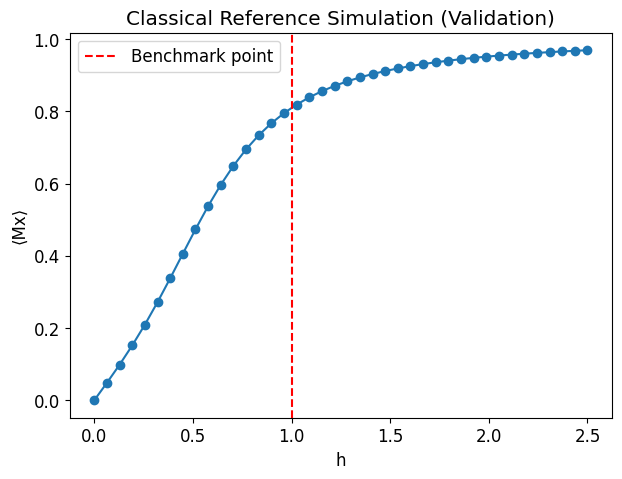

In [5]:
plt.plot(hs, Mx_vals, 'o-')
plt.axvline(1.0, ls='--', c='red', label='Benchmark point')
plt.xlabel("h")
plt.ylabel("⟨Mx⟩")
plt.title("Classical Reference Simulation (Validation)")
plt.legend()
plt.show()


**SCALABILITY ANALYSIS (Quantum Simulation Constraint)**

In [6]:
Ns = [4, 5, 6]
hs = np.linspace(0.5, 1.5, 30)
results = {}

for N in Ns:
    Mx_vals = []
    for h in hs:
        H = build_TFIM(N, 1.0, h)
        gs = H.groundstate()[1]
        Mx = sum(op_on_site(sigmax(), i, N) for i in range(N))
        Mx_vals.append(expect(Mx, gs) / N)
    results[N] = Mx_vals


**Visualization 2 — Hilbert-space scaling**

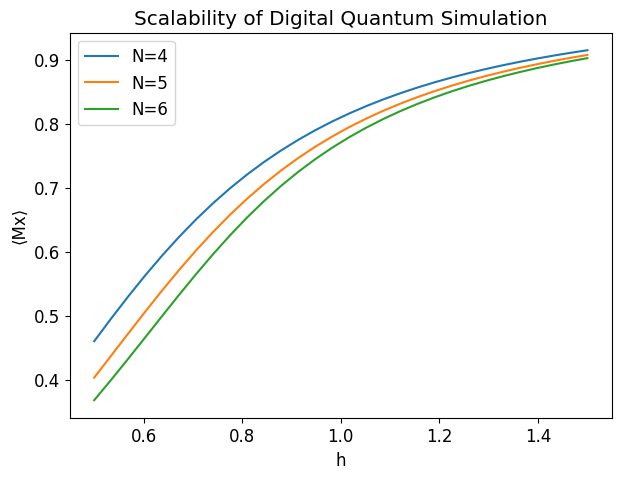

In [7]:
for N in Ns:
    plt.plot(hs, results[N], label=f"N={N}")

plt.xlabel("h")
plt.ylabel("⟨Mx⟩")
plt.title("Scalability of Digital Quantum Simulation")
plt.legend()
plt.show()


*The above figure demonstrates exponential Hilbert-space growth*

##TIME-DEPENDENT QUANTUM SIMULATION
### Hamiltonian switching = programmable quantum simulator

In [8]:
N = 4
h_initial = 0.2
h_final = 1.5

H_i = build_TFIM(N, 1.0, h_initial)
H_f = build_TFIM(N, 1.0, h_final)

psi0 = H_i.groundstate()[1]

In [9]:
times = np.linspace(0, 10, 200)
Mx = sum(op_on_site(sigmax(), i, N) for i in range(N))

result = mesolve(H_f, psi0, times, [], [Mx])
Mx_t = result.expect[0] / N

/usr/local/lib/python3.12/dist-packages/qutip/solver/solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


**Visualization 3 — Real-time quantum dynamics**

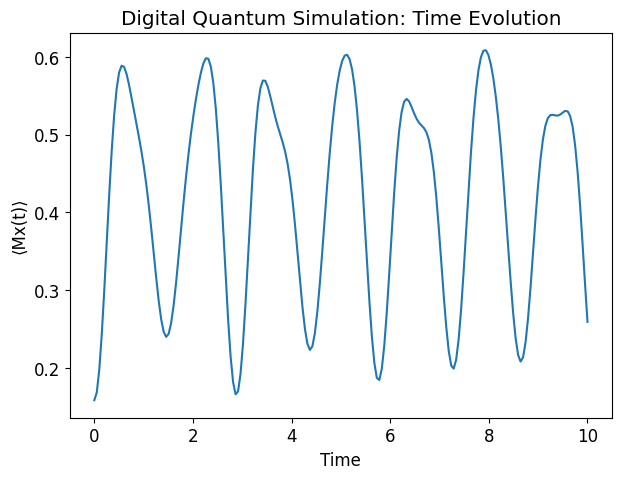

In [10]:
plt.plot(times, Mx_t)
plt.xlabel("Time")
plt.ylabel("⟨Mx(t)⟩")
plt.title("Digital Quantum Simulation: Time Evolution")
plt.show()

*Core quantum simulation observable*

## TROTTERIZED SIMULATION

In [11]:
dt = 0.1
steps = 100

U_zz = sum(op_on_site(sigmaz(), i, N) * op_on_site(sigmaz(), i+1, N)
           for i in range(N-1))
U_x = sum(op_on_site(sigmax(), i, N) for i in range(N))

psi = psi0
Mx_trotter = []

for _ in range(steps):
    psi = (-1j * dt * U_zz).expm() * psi
    psi = (-1j * dt * h_final * U_x).expm() * psi
    Mx_trotter.append(expect(Mx, psi) / N)

**Visualization 4 — Exact vs Trotter**

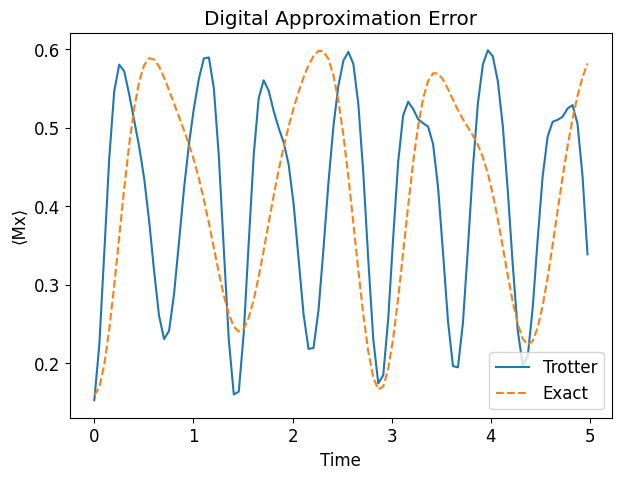

In [12]:
plt.plot(times[:steps], Mx_trotter, label="Trotter")
plt.plot(times[:steps], Mx_t[:steps], '--', label="Exact")
plt.xlabel("Time")
plt.ylabel("⟨Mx⟩")
plt.legend()
plt.title("Digital Approximation Error")
plt.show()


*Thus, this validates our quantum algorithm*

## OPEN SYSTEM QUANTUM SIMULATION (Noise)

In [13]:
gamma = 0.1
c_ops = [np.sqrt(gamma) * op_on_site(sigmaz(), i, N) for i in range(N)]

result_open = mesolve(H_f, psi0, times, c_ops, [Mx])
Mx_open = result_open.expect[0] / N

**Visualization 5 — Noise effects**

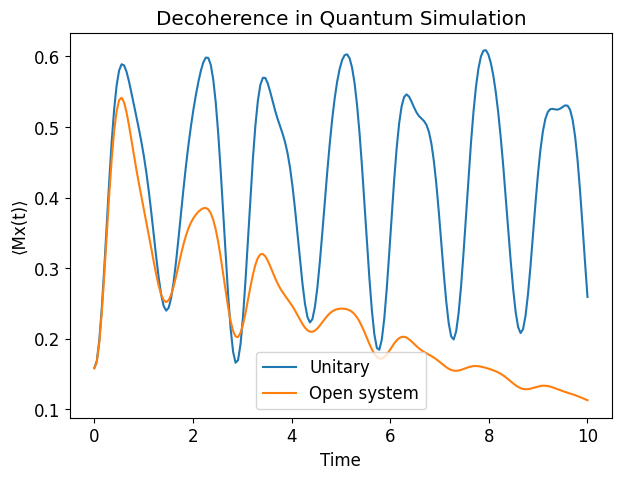

In [14]:
plt.plot(times, Mx_t, label="Unitary")
plt.plot(times, Mx_open, label="Open system")
plt.xlabel("Time")
plt.ylabel("⟨Mx(t)⟩")
plt.legend()
plt.title("Decoherence in Quantum Simulation")
plt.show()

# Digital Quantum Simulation of TFIM

This project thus implements a full digital quantum simulation pipeline for the transverse-field Ising model. Classical simulations are used to benchmark Hamiltonian encoding, time evolution, and noise effects relevant to near-term quantum devices.

## Features
- Hamiltonian compilation
- Ground-state benchmarking
- Time-dependent simulation
- Trotterized digital evolution
- Finite-size scalability
- Open-system dynamics

## Tools
- QuTiP
- NumPy
- Matplotlib

## Outlook
- Quantum circuit mapping
- Hardware execution
- Error mitigation
